In [1]:
# 1. Install essential libraries for 4-bit fine-tuning
# Force-install only necessary components without touching system-critical dependencies
!pip install --no-deps "xformers<0.0.30" "trl<0.13.0" peft accelerate bitsandbytes
!pip install --no-deps unsloth
!pip install --no-deps unsloth_zoo



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.7/405.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 18.8 MB/s eta 0:00:00


In [2]:
# 2. Import core modules
import torch
from unsloth import FastLanguageModel
from datasets import load_dataset
import pandas as pd

# Verify the GPU is detected and Unsloth is ready
major_version, minor_version = torch.cuda.get_device_capability()
print(f"CUDA Capability: {major_version}.{minor_version}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
CUDA Capability: 7.5


In [9]:
# Load the CSV file
# Ensure the file 'Finance Data (val).csv' is uploaded to your Colab session storage

# Explicitly set the delimiter to '|' and define column names, assuming no header
# The names 'id', 'numeric_value', 'transcript' are inferred from the user's provided data
column_names = ['id', 'numeric_value', 'transcript']

try:
    dataset = load_dataset('csv', data_files='Finance Data (val).csv', split='train', delimiter='|', column_names=column_names)
    print("Successfully loaded dataset with '|' delimiter and explicit column names.")
except Exception as e:
    print(f"Failed to load dataset with '|' delimiter and explicit column names using datasets library: {e}")
    print("Trying with pandas and more robust error handling.")
    # Fallback to pandas with error handling for problematic lines
    try:
        # Using the same delimiter and header settings for consistency
        df = pd.read_csv('Finance Data (val).csv', sep='|', header=None, names=column_names, on_bad_lines='warn')
        from datasets import Dataset
        dataset = Dataset.from_pandas(df)
        print("Successfully loaded dataset using pandas with error handling.")
    except Exception as pd_e:
        print(f"Could not load CSV even with pandas error handling and '|' delimiter: {pd_e}")
        print("Please check the file 'Finance Data (val).csv' for inconsistencies, especially around line 129.")

# Display the first transcript to verify successful loading
if 'dataset' in locals() and dataset is not None:
    print(dataset[0]['transcript'])

Generating train split: 0 examples [00:00, ? examples/s]

Successfully loaded dataset with '|' delimiter and explicit column names.
transcript


In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit", # Specifically for T4 GPU efficiency
    max_seq_length = 2048,                      # Standard context window
    load_in_4bit = True,                        # Critical for memory saving
    dtype = None,                               # Auto-detection for T4
)

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [5]:
# Define the prompt style for your financial domain
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [10]:
dataset

Dataset({
    features: ['id', 'numeric_value', 'transcript'],
    num_rows: 16737
})

In [11]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    instructions = "Continue the financial transcript in a professional and accurate tone."
    inputs       = "" # We leave this blank if the transcript is self-contained
    outputs      = examples["transcript"]
    texts = []
    for instruction, input, output in zip([instructions]*len(outputs), [inputs]*len(outputs), outputs):
        # Must add EOS_TOKEN, otherwise generation will go on forever!
        t = prompt_style.format(instruction, input, output) + EOS_TOKEN
        texts.append(t)
    return { "text" : texts, }

# Apply the formatting to your dataset
dataset = dataset.map(formatting_prompts_func, batched = True)

# Print one example to see the final format for your report
print(dataset[0]["text"])

Map:   0%|          | 0/16737 [00:00<?, ? examples/s]

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the financial transcript in a professional and accurate tone.

### Input:


### Response:
transcript<|end_of_text|>


# Split Dataset
Split the `dataset` into `train_dataset` (95%) and `eval_dataset` (5%) using `train_test_split` from the `datasets` library after it has been formatted. Then, configure the `SFTTrainer` to train on the `train_dataset` and evaluate on the `eval_dataset` by updating cell `yJ6o1uBFuVOQ`. Finally, update cell `jiedZu2N-phh` to calculate and present the perplexity on the `eval_dataset` to assess the model's generalization performance.

In [12]:

# Split the dataset into training (95%) and evaluation (5%)
split_dataset = dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Evaluation dataset size: {len(eval_dataset)}")

# Print one example from the training dataset to see the final format for your report
print(train_dataset[0]["text"])

Training dataset size: 15900
Evaluation dataset size: 837
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the financial transcript in a professional and accurate tone.

### Input:


### Response:
Is there a point when it changes to try to attract new customer? Or is the current style the best way to generate profitable<|end_of_text|>


In [13]:

model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Optimized at 0
    bias = "none",    # Optimized at "none"
    use_gradient_checkpointing = "unsloth", # Use 30% less VRAM
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2026.1.4 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [14]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Updated Training Arguments with Evaluation Strategy
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 8,
    warmup_steps = 5,
    max_steps = 60,
    learning_rate = 1e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),

    logging_steps = 1,
    report_to = "none",

    # NEW: Evaluation Strategy
    eval_strategy = "steps", # Options: "no", "steps", "epoch"
    eval_steps = 10,               # Evaluate every 10 steps
    per_device_eval_batch_size = 1, # Smaller batch size for evaluation to save memory

    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "outputs",
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset, # Use the original split dataset
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    args = training_args,
)

# Start Training
trainer.train()

/content/unsloth_compiled_cache/UnslothSFTTrainer.py:875: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/content/unsloth_compiled_cache/UnslothSFTTrainer.py:889: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/content/unsloth_compiled_cache/UnslothSFTTrainer.py:903: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map (num_proc=2):   0%|          | 0/15900 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/837 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 15,900 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss,Validation Loss
10,2.824000,2.663525
20,1.512200,1.449615
30,1.455500,1.379073
40,1.288100,1.353969
50,1.413700,1.342673
60,1.373500,1.339280


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=60, training_loss=1.829460479815801, metrics={'train_runtime': 425.6627, 'train_samples_per_second': 2.255, 'train_steps_per_second': 0.141, 'total_flos': 466945040646144.0, 'train_loss': 1.829460479815801, 'epoch': 0.06037735849056604})

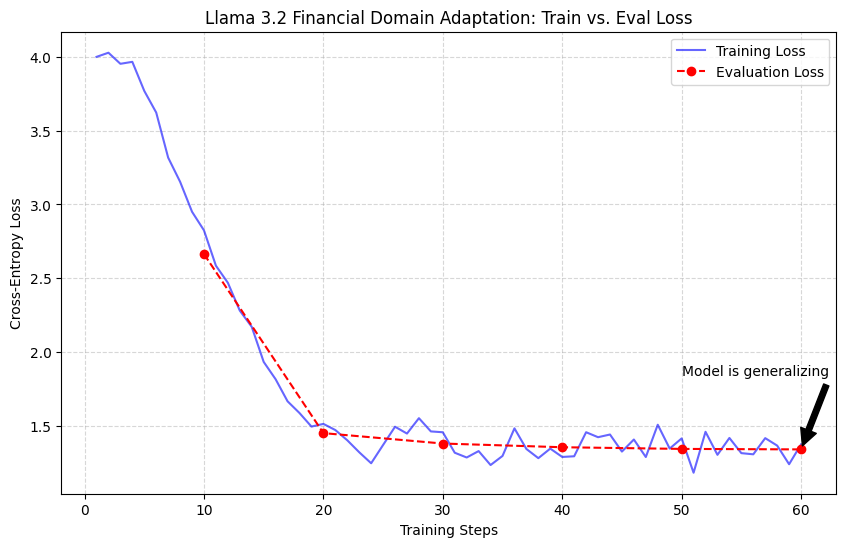

In [15]:
import matplotlib.pyplot as plt

# 1. Extract Training and Evaluation logs
history = trainer.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for entry in history:
    if 'loss' in entry: # Training loss entries
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry: # Evaluation loss entries
        eval_steps.append(entry['step'])
        eval_loss.append(entry['eval_loss'])

# 2. Plotting
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(train_steps, train_loss, label="Training Loss", color='blue', alpha=0.6)

# Plot Evaluation Loss (using markers to distinguish it)
plt.plot(eval_steps, eval_loss, label="Evaluation Loss", color='red', marker='o', linestyle='--')

plt.xlabel("Training Steps")
plt.ylabel("Cross-Entropy Loss")
plt.title("Llama 3.2 Financial Domain Adaptation: Train vs. Eval Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 3. Add a visual note for your report
plt.annotate('Model is generalizing', xy=(eval_steps[-1], eval_loss[-1]),
             xytext=(eval_steps[-1]-10, eval_loss[-1]+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## Perplexity

In [22]:
import math
import torch

def get_perplexity_stable(dataset_to_eval, name):
    print(f"Starting {name} processing...")

    # 1. Tokenize without parallel proc to avoid freezing
    def tokenize_function(examples):
        tokens = tokenizer(
            examples["text"],
            truncation=True,
            max_length=1024, # Reduced slightly for faster processing
            padding="max_length",
        )
        tokens["labels"] = tokens["input_ids"].copy()
        return tokens

    # Map without num_proc to ensure it finishes
    tokenized_ds = dataset_to_eval.map(
        tokenize_function,
        batched=True,
        batch_size=1000,
        remove_columns=dataset_to_eval.column_names
    )

    tokenized_ds.set_format("torch")

    # 2. Evaluate
    trainer.args.remove_unused_columns = True
    results = trainer.evaluate(eval_dataset=tokenized_ds)

    ppl = math.exp(results['eval_loss'])
    return results['eval_loss'], ppl

# Try running just the Testing Data first to save time
test_loss, test_ppl = get_perplexity_stable(eval_dataset, "Testing Data")
print(f"Testing Perplexity: {test_ppl:.4f}")

Starting Testing Data processing...


Map:   0%|          | 0/837 [00:00<?, ? examples/s]

Testing Perplexity: 4.7976


## Qualitative Inference Test

In [25]:
import pandas as pd
from unsloth import FastLanguageModel

# 1. Ensure model is ready for inference
FastLanguageModel.for_inference(model)

# 2. Use the original eval_dataset to access the 'transcript' column
# We only need 10 for a high-quality "Results" table
test_samples = eval_dataset.select(range(10))

print("FINANCIAL DOMAIN GENERATION RESULTS")
print("="*50)

results_for_report = []

for i, sample in enumerate(test_samples):
    # Use the 'text' column if 'transcript' was deleted, or vice versa
    # We'll grab the first few words to act as a 'seed' for the model
    full_text = sample["text"]
    # We extract the part that was the original transcript (after the Response: marker)
    if "### Response:\n" in full_text:
        original_transcript = full_text.split("### Response:\n")[-1].replace("<|end_of_text|>", "").strip()
    else:
        original_transcript = full_text

    context_snippet = " ".join(original_transcript.split()[:12]) # First 12 words

    prompt = prompt_style.format(
        "Continue the financial transcript in a professional and accurate tone.",
        f"Context: {context_snippet}",
        "" # Leave response empty for the model to fill
    )

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Use sampling (temperature) for more natural professional language
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.batch_decode(outputs)[0]

    # Clean the output
    response = decoded.split("### Response:\n")[-1].replace("<|end_of_text|>", "").strip()

    print(f"\n[Sample {i+1}]")
    print(f"INPUT SNIPPET: {context_snippet}...")
    print(f"MODEL OUTPUT:  {response}")

    results_for_report.append({"Context Snippet": context_snippet, "Model Completion": response})

# 3. Create the table for Section C
df_results = pd.DataFrame(results_for_report)

FINANCIAL DOMAIN GENERATION RESULTS

[Sample 1]
INPUT SNIPPET: When you need to rely on interpreters for everything,...
MODEL OUTPUT:  That's why we're really excited about this new capability

[Sample 2]
INPUT SNIPPET: Now I would like to turn the call over to Matt to...
MODEL OUTPUT:  Thank you, and good morning. And thank you for joining us today.

[Sample 3]
INPUT SNIPPET: Also, engineering became more specific as it relates to the equipment as...
MODEL OUTPUT:  of the equipment. We have been working with our engineering team to define the

[Sample 4]
INPUT SNIPPET: our mill operations are highly integrated with our converting platform as we...
MODEL OUTPUT:  With respect to the mill, our goal is to continue to execute our plan and

[Sample 5]
INPUT SNIPPET: Our goal is to be the trusted energy company. And we'll do...
MODEL OUTPUT:  The focus is on our ability to execute our business plan.

[Sample 6]
INPUT SNIPPET: driven by the increased attractiveness of U.S. dollar products in